In [ ]:
### Cell 1: Install Dependencies ###
!pip install fathomnet
!pip install -q pillow matpl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement matpl (from versions: none)
ERROR: No matching distribution found for matpl


In [ ]:
### Cell 2: Mount Google Drive ###
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/FathomNet_Project')

print("Path added. Folders inside project:")

Mounted at /content/drive
Path added. Folders inside project:


In [ ]:
### Cell 3: Import All Modules ###
from src.config import Config
from src.data.explorer import FathomNetExplorer
from src.data.downloader import FathomNetDownloader
from src.data.dataset import MarineOrganismDataset
from src.data.transforms import TransformFactory
from src.data.dataloader import DataLoaderFactory
from src.data.copier import LocalDiskCopier
from src.models.cnn_scratch import CNNFromScratch
from src.models.transfer_learning import TransferLearningModel
from src.training.trainer import Trainer
from src.training.checkpoint import CheckpointManager
from src.evaluation.evaluator import ModelEvaluator, HyperparameterComparator
from src.evaluation.ood_detection import OODDetector, OODAnalyzer
from src.visualization.plots import Visualizer

import torch
import numpy as np
import json
import os
from tqdm import tqdm

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

print("✓ All modules imported successfully!")

✓ All modules imported successfully!


In [ ]:
### Cell 4: Configuration ###
# Configure for 8 classes (run separate notebook for 20 classes)
config = Config(
    num_classes=8,
    img_size=160,
    batch_size=64,
    epochs=10,
    learning_rate_scratch=0.001,
    learning_rate_transfer=0.0001,
    save_all_checkpoints=True,  # Set True to keep all checkpoints
    max_checkpoints=5,
    ood_threshold=0.88,
    ood_classes_to_holdout=2
)

print("Configuration:")
for key, value in config.to_dict().items():
    print(f"  {key}: {value}")
print(f"  Device: {config.device}")

Configuration:
  num_classes: 8
  img_size: 160
  batch_size: 64
  epochs: 10
  learning_rate_scratch: 0.001
  learning_rate_transfer: 0.0001
  Device: cuda


PHASE 1: DATABASE EXPLORATION
✓ Loading cached exploration data...
Loaded data for 2724 species

DATABASE STATISTICS
Total species: 2724
Total images: 321,349

Image Count Statistics:
  Mean:     118.0
  Median:   6.0
  Std Dev:  900.0
  Min:      1
  Max:      37,486

Percentiles:
  25th: 2.0
  50th: 6.0
  75th: 30.2
  90th: 164.0
  95th: 424.4
  99th: 2012.5



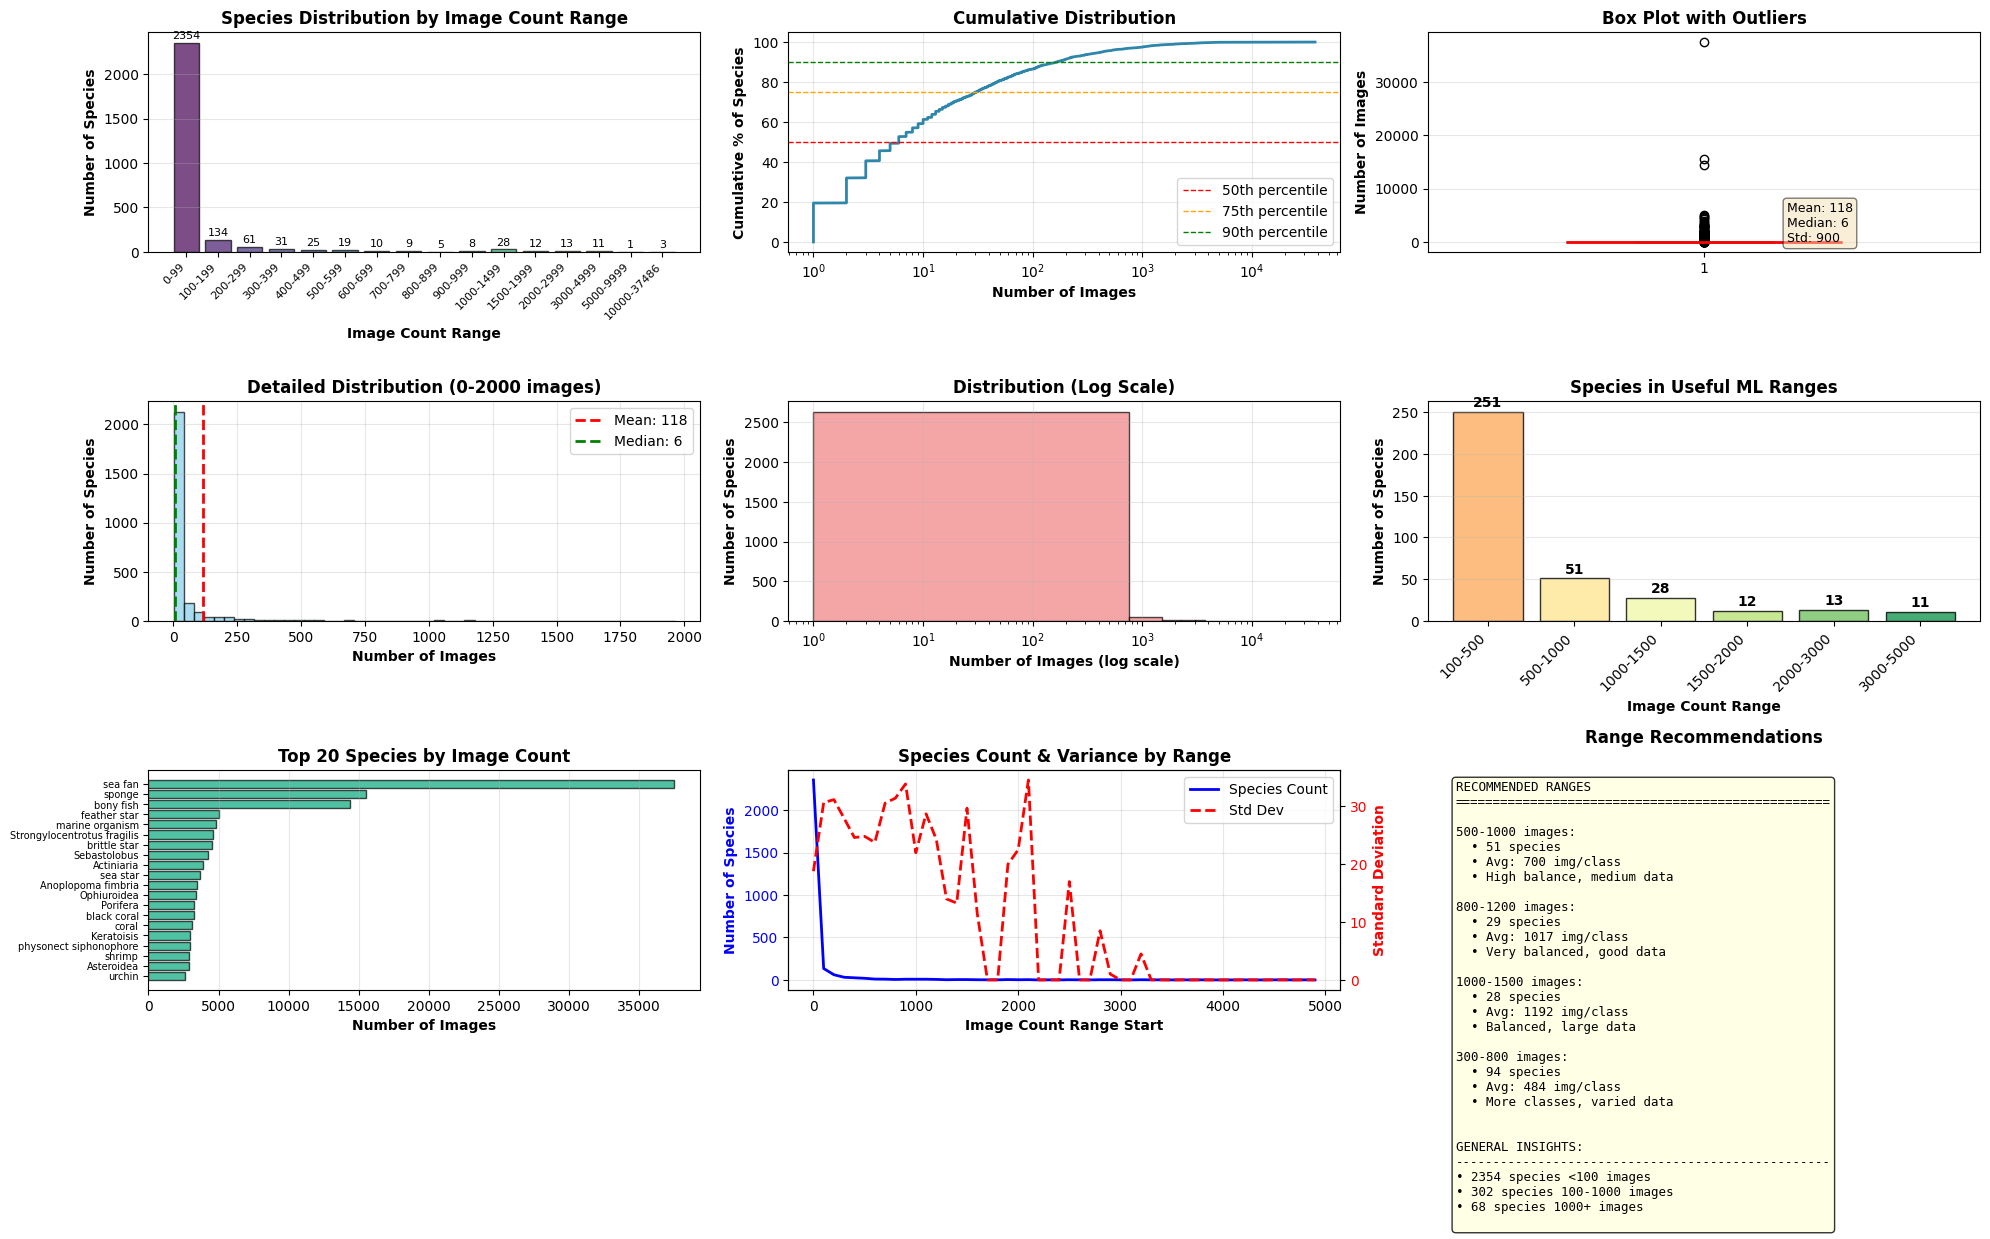

✓ Exploration visualization saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/fathomnet_exploration.png


'/content/drive/MyDrive/FathomNet_Project/results_8classes/fathomnet_exploration.png'

In [ ]:
### Cell 5: Database Exploration (EDA) ###
print("="*80)
print("PHASE 1: DATABASE EXPLORATION")
print("="*80)

explorer = FathomNetExplorer(config.data_dir)

# Scan database (cached if already done)
all_species_counts = explorer.scan_database(force_rescan=False)

# Print statistics
explorer.print_statistics()

# Generate comprehensive visualizations
explorer.plot_comprehensive_analysis(config.results_dir)

In [ ]:
### Cell 6: Species Selection & Metadata Download ###
print("\n" + "="*80)
print("PHASE 2: DATA PREPARATION")
print("="*80)

# Download configuration
MIN_IMAGES = 800
MAX_IMAGES = 1200
TARGET_NUM_CLASSES = config.num_classes

downloader = FathomNetDownloader(config.data_dir, config.images_dir)

# Check if species already selected
species_info_path = config.get_species_info_path()

if os.path.exists(species_info_path):
    print("✓ Loading existing species selection...")
    with open(species_info_path, 'r') as f:
        species_info = json.load(f)
    selected_species_names = species_info['selected_species']
    selected_species_details = species_info['species_details']
    print(f"Loaded {len(selected_species_names)} species")
else:
    print("Selecting species...")
    selected_species_names, selected_species_details = downloader.select_species(
        MIN_IMAGES, MAX_IMAGES, TARGET_NUM_CLASSES,
        os.path.join(config.data_dir, 'fathomnet_exploration.json')
    )

    # Save species info
    species_info = {
        'selected_species': selected_species_names,
        'species_details': selected_species_details,
        'selection_criteria': {
            'min_images': MIN_IMAGES,
            'max_images': MAX_IMAGES,
            'target_num_classes': TARGET_NUM_CLASSES
        }
    }
    with open(species_info_path, 'w') as f:
        json.dump(species_info, f, indent=2)

# Download metadata
metadata_path = os.path.join(config.data_dir, f'fathomnet_metadata_{config.num_classes}classes.json')

if os.path.exists(metadata_path):
    print("✓ Loading existing metadata...")
    with open(metadata_path, 'r') as f:
        all_metadata = json.load(f)
else:
    print("Downloading metadata...")
    all_metadata = downloader.download_metadata(selected_species_names)
    with open(metadata_path, 'w') as f:
        json.dump(all_metadata, f, indent=2)

print(f"\n✓ Total images in metadata: {len(all_metadata):,}")


PHASE 2: DATA PREPARATION
✓ Loading existing species selection...
Loaded 8 species
✓ Loading existing metadata...

✓ Total images in metadata: 8,074



PHASE 3: IMAGE DOWNLOAD
PARALLEL IMAGE DOWNLOAD
Configuration:
  Workers: 100
  Total images: 8,074

Scanning for existing downloads...
✓ Found 8,071 already downloaded
  Remaining: 3



Downloading: 100%|██████████| 8074/8074 [00:09<00:00, 826.94it/s, new=0, cached=8071, failed=3] 



DOWNLOAD COMPLETE!
Results:
  ✓ Newly downloaded: 0
  ✓ Already cached:   8,071
  ✗ Failed:          3
  ─────────────────────────
  Total images:      8,071
  Success rate:      100.0%

⚠ Failed URLs saved to: /content/drive/MyDrive/FathomNet_Project/data/failed_downloads.json


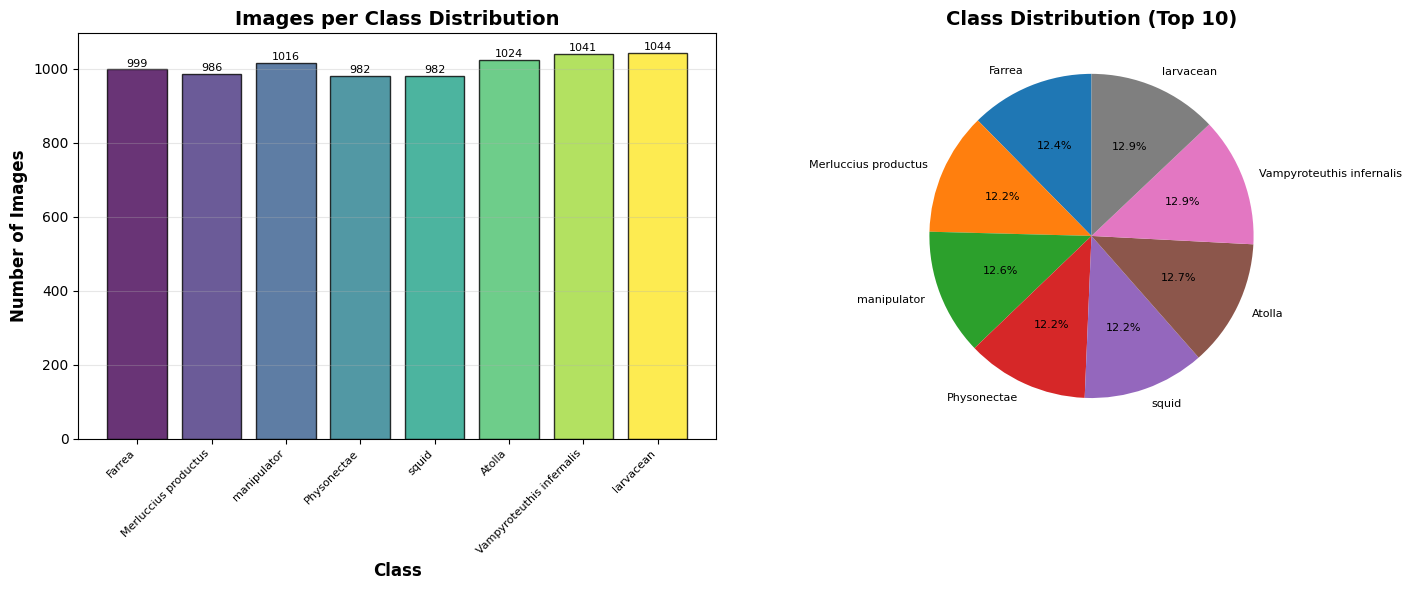

✓ Class distribution saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/selected_dataset_distribution.png


'/content/drive/MyDrive/FathomNet_Project/results_8classes/selected_dataset_distribution.png'

In [ ]:
### Cell 7: Download Images (Parallel) ###
print("\n" + "="*80)
print("PHASE 3: IMAGE DOWNLOAD")
print("="*80)

# Download images in parallel
download_results = downloader.download_images_parallel(all_metadata)

# Visualize dataset distribution
visualizer = Visualizer(config.results_dir)
class_counts = {}
for meta in all_metadata:
    species = meta['concept']
    class_counts[species] = class_counts.get(species, 0) + 1

visualizer.plot_class_distribution(class_counts,
                                  filename='selected_dataset_distribution.png')

In [ ]:
### Cell 7.5: Copy Images to Local Disk (FAST) ###
print("\n" + "="*80)
print("PHASE 3B: COPY TO LOCAL DISK FOR FASTER TRAINING")
print("="*80)

# Initialize copier
copier = LocalDiskCopier(
    source_dir=config.images_dir,
    local_dir=config.local_images_dir
)

# Copy selected species to local disk
copy_stats = copier.copy_selected_species(
    selected_species_names,
    max_workers=10,
    show_progress=True
)

# Verify copy
copier.verify_copy(selected_species_names)

# UPDATE config to use local disk for all subsequent operations
config.images_dir = config.local_images_dir
print(f"\n✓ Config updated to use LOCAL DISK: {config.images_dir}")
print("✓ All subsequent operations will be MUCH faster!")


PHASE 3B: COPY TO LOCAL DISK FOR FASTER TRAINING
COPYING SELECTED SPECIES TO LOCAL DISK
Source: /content/drive/MyDrive/FathomNet_Project/data/images
Destination: /content/fathomnet_images
Species to copy: 8
Workers: 10



Copying classes: 100%|██████████| 8/8 [10:15<00:00, 76.97s/it, current=Farrea, files=999]


COPY COMPLETE!
  Successful: 8/8 classes
  Failed: 0
  Total files: 8,071
  Time: 615.8s (10.3 min)
  Speed: 13.1 files/s

VERIFYING COPIED SPECIES
Expected: 8 classes
Found: 8 classes
✓ All classes verified!
  Total files: 8,071

✓ Config updated to use LOCAL DISK: /content/fathomnet_images
✓ All subsequent operations will be MUCH faster!



PHASE 4: IMAGE PROPERTIES ANALYSIS


Analyzing images: 100%|██████████| 500/500 [00:00<00:00, 857.66it/s]



Image Statistics (n=500):
  Width:  Mean=1702.1, Range=[640, 4000]
  Height: Mean=972.4, Range=[366, 3000]
  Aspect: Mean=1.75
  Size:   Mean=393.9 KB


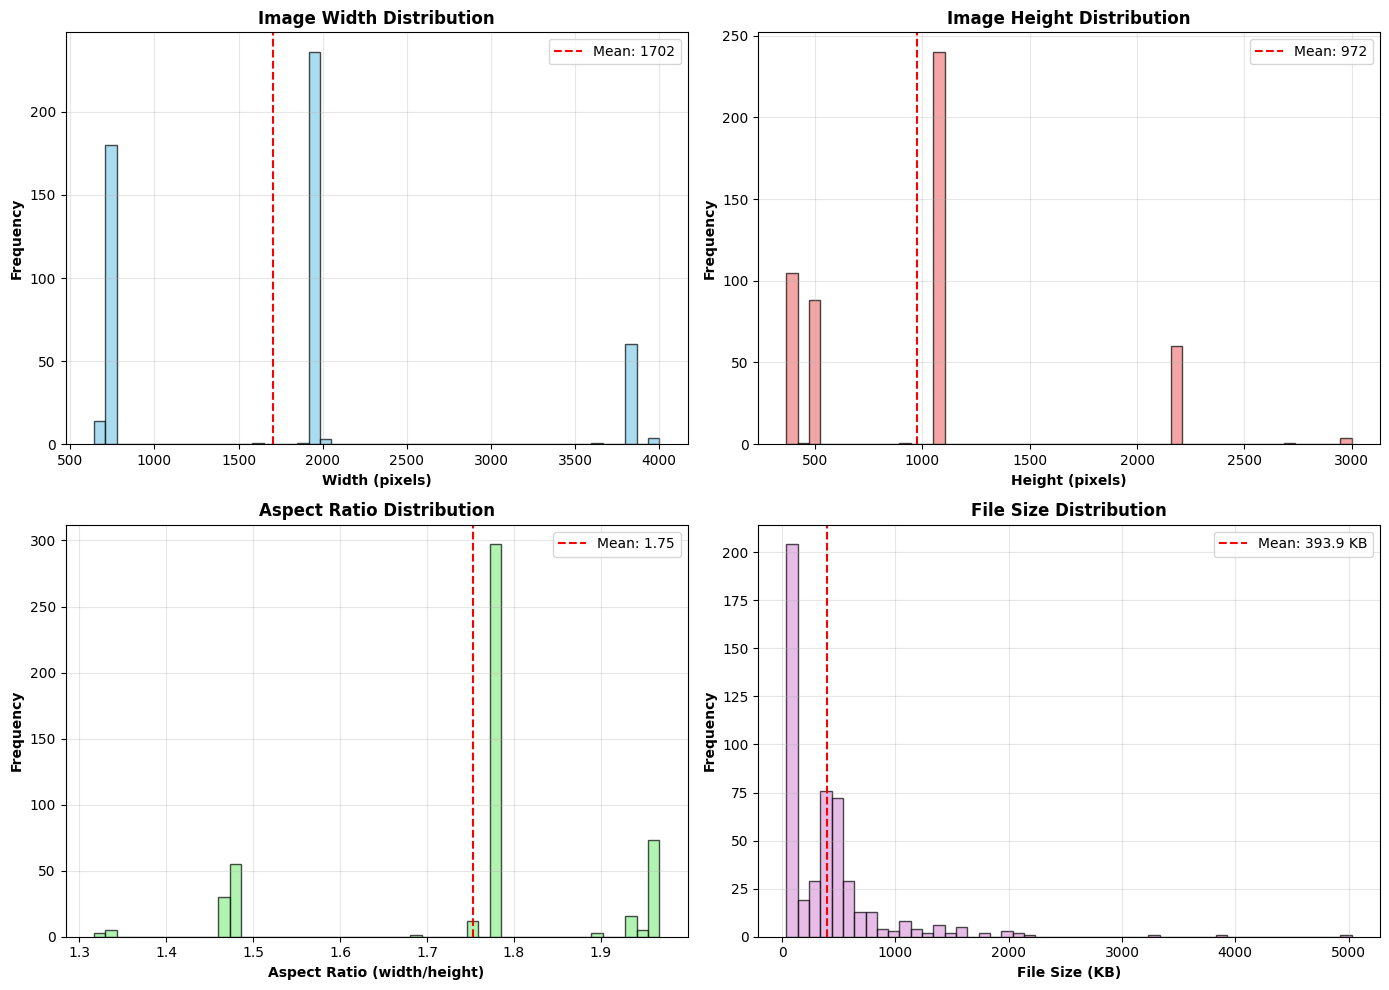

✓ Image properties saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/image_properties.png


'/content/drive/MyDrive/FathomNet_Project/results_8classes/image_properties.png'

In [ ]:
### Cell 8: Image Properties Analysis (EDA) ###
print("\n" + "="*80)
print("PHASE 4: IMAGE PROPERTIES ANALYSIS")
print("="*80)

# Sample images for analysis
from PIL import Image
sample_size = 500
image_stats = {
    'widths': [],
    'heights': [],
    'aspect_ratios': [],
    'file_sizes': []
}

sampled_metadata = np.random.choice(all_metadata,
                                    min(sample_size, len(all_metadata)),
                                    replace=False)

for meta in tqdm(sampled_metadata, desc="Analyzing images"):
    try:
        species_dir = meta['concept'].replace(' ', '_').replace('/', '_')
        img_path = os.path.join(config.images_dir, species_dir, f"{meta['uuid']}.jpg")

        if os.path.exists(img_path):
            img = Image.open(img_path)
            image_stats['widths'].append(img.width)
            image_stats['heights'].append(img.height)
            image_stats['aspect_ratios'].append(img.width / img.height)
            image_stats['file_sizes'].append(os.path.getsize(img_path) / 1024)
    except:
        continue

# Convert to numpy arrays
for key in image_stats:
    image_stats[key] = np.array(image_stats[key])

# Print statistics
print(f"\nImage Statistics (n={len(image_stats['widths'])}):")
print(f"  Width:  Mean={image_stats['widths'].mean():.1f}, "
      f"Range=[{image_stats['widths'].min()}, {image_stats['widths'].max()}]")
print(f"  Height: Mean={image_stats['heights'].mean():.1f}, "
      f"Range=[{image_stats['heights'].min()}, {image_stats['heights'].max()}]")
print(f"  Aspect: Mean={image_stats['aspect_ratios'].mean():.2f}")
print(f"  Size:   Mean={image_stats['file_sizes'].mean():.1f} KB")

# Visualize
visualizer.plot_image_properties(image_stats)


In [ ]:
### Cell 9: Data Splitting ###
print("\n" + "="*80)
print("PHASE 5: DATA SPLITTING")
print("="*80)

split_file_path = config.get_split_file_path()

if os.path.exists(split_file_path):
    print("✓ Loading existing data split...")
    with open(split_file_path, 'r') as f:
        data_split = json.load(f)

    train_files = data_split['train']
    val_files = data_split['val']
    test_files = data_split['test']
    ood_files = data_split['ood']
    class_to_idx = data_split['class_to_idx']
    ood_classes = data_split['ood_classes']

else:
    print("Creating new data split...")

    # Select OOD classes
    valid_classes = list(set([m['concept'] for m in all_metadata]))
    ood_classes = np.random.choice(valid_classes,
                                   config.ood_classes_to_holdout,
                                   replace=False).tolist()
    train_classes = [c for c in valid_classes if c not in ood_classes]

    # Create class to index mapping
    class_to_idx = {cls: idx for idx, cls in enumerate(sorted(train_classes))}

    # Split data
    train_files = []
    val_files = []
    test_files = []
    ood_files = []

    for class_name in train_classes:
        # Get images for this class
        class_dir = class_name.replace(' ', '_').replace('/', '_')
        class_path = os.path.join(config.images_dir, class_dir)
        image_files = [os.path.join(class_path, f)
                      for f in os.listdir(class_path) if f.endswith('.jpg')]

        np.random.shuffle(image_files)

        # Split
        n_train = int(len(image_files) * config.train_ratio)
        n_val = int(len(image_files) * config.val_ratio)

        train_files.extend([(f, class_to_idx[class_name])
                           for f in image_files[:n_train]])
        val_files.extend([(f, class_to_idx[class_name])
                         for f in image_files[n_train:n_train+n_val]])
        test_files.extend([(f, class_to_idx[class_name])
                          for f in image_files[n_train+n_val:]])

    # OOD files
    for class_name in ood_classes:
        class_dir = class_name.replace(' ', '_').replace('/', '_')
        class_path = os.path.join(config.images_dir, class_dir)
        image_files = [os.path.join(class_path, f)
                      for f in os.listdir(class_path) if f.endswith('.jpg')]
        ood_files.extend([(f, -1) for f in image_files])

    # Shuffle
    np.random.shuffle(train_files)
    np.random.shuffle(val_files)
    np.random.shuffle(test_files)
    np.random.shuffle(ood_files)

    # Save split
    data_split = {
        'train': train_files,
        'val': val_files,
        'test': test_files,
        'ood': ood_files,
        'class_to_idx': class_to_idx,
        'ood_classes': ood_classes
    }

    with open(split_file_path, 'w') as f:
        json.dump(data_split, f, indent=2)

print(f"✓ Train: {len(train_files)}, Val: {len(val_files)}, "
      f"Test: {len(test_files)}, OOD: {len(ood_files)}")
print(f"✓ Training classes: {len(class_to_idx)}")
print(f"✓ OOD classes: {ood_classes}")

# Create reverse mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}



PHASE 5: DATA SPLITTING
✓ Loading existing data split...
✓ Train: 4247, Val: 908, Test: 917, OOD: 1999
✓ Training classes: 6
✓ OOD classes: ['manipulator', 'Merluccius productus']


In [ ]:
### Cell 10: Create Datasets & DataLoaders ###
print("\n" + "="*80)
print("PHASE 6: DATALOADER CREATION")
print("="*80)

# Create transforms
transform_factory = TransformFactory()
train_transform = transform_factory.get_train_transform(config.img_size)
eval_transform = transform_factory.get_eval_transform(config.img_size)

# Create datasets
train_dataset = MarineOrganismDataset(train_files, train_transform)
val_dataset = MarineOrganismDataset(val_files, eval_transform)
test_dataset = MarineOrganismDataset(test_files, eval_transform)
ood_dataset = MarineOrganismDataset(ood_files, eval_transform)

# Create dataloaders
train_loader, val_loader, test_loader, ood_loader = DataLoaderFactory.create_loaders(
    config, train_dataset, val_dataset, test_dataset, ood_dataset
)

print(f"✓ DataLoaders created!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  OOD batches: {len(ood_loader)}")



PHASE 6: DATALOADER CREATION
✓ DataLoaders created!
  Train batches: 66
  Val batches: 8
  Test batches: 8
  OOD batches: 16


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
### Cell 11: Train CNN from Scratch - Config 1 ###
print("\n" + "="*80)
print("PHASE 7: TRAINING - CNN FROM SCRATCH")
print("="*80)

# Configuration 1: Learning Rate = 0.001
print("\n[CNN SCRATCH - CONFIG 1: LR=0.001]")
model_scratch_1 = CNNFromScratch(config.num_classes)
trainer_scratch_1 = Trainer(config, model_scratch_1, 'cnn_scratch_lr0.001')

history_scratch_1, best_val_acc_1 = trainer_scratch_1.train(
    train_loader, val_loader,
    learning_rate=0.001,
    num_epochs=config.epochs,
    resume=True
)

print(f"\n✓ Config 1 Best Val Acc: {best_val_acc_1:.2f}%")


PHASE 7: TRAINING - CNN FROM SCRATCH

[CNN SCRATCH - CONFIG 1: LR=0.001]


/content/drive/MyDrive/FathomNet_Project/src/training/trainer.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


✓ Loaded checkpoint from epoch 10
✓ Resuming from epoch 11

TRAINING: cnn_scratch_lr0.001
Learning Rate: 0.001
Epochs: 11 to 10
Batch Size: 64
Num Classes: 8


TRAINING COMPLETE: cnn_scratch_lr0.001
Best Val Acc: 49.89%


✓ Config 1 Best Val Acc: 49.89%


In [ ]:
### Cell 12: Train CNN from Scratch - Config 2 ###
print("\n[CNN SCRATCH - CONFIG 2: LR=0.0005]")
model_scratch_2 = CNNFromScratch(config.num_classes)
trainer_scratch_2 = Trainer(config, model_scratch_2, 'cnn_scratch_lr0.0005')

history_scratch_2, best_val_acc_2 = trainer_scratch_2.train(
    train_loader, val_loader,
    learning_rate=0.0005,
    num_epochs=config.epochs,
    resume=True
)

print(f"\n✓ Config 2 Best Val Acc: {best_val_acc_2:.2f}%")


[CNN SCRATCH - CONFIG 2: LR=0.0005]
✓ Loaded checkpoint from epoch 10
✓ Resuming from epoch 11

TRAINING: cnn_scratch_lr0.0005
Learning Rate: 0.0005
Epochs: 11 to 10
Batch Size: 64
Num Classes: 8


TRAINING COMPLETE: cnn_scratch_lr0.0005
Best Val Acc: 53.41%


✓ Config 2 Best Val Acc: 53.41%



CNN SCRATCH - HYPERPARAMETER COMPARISON


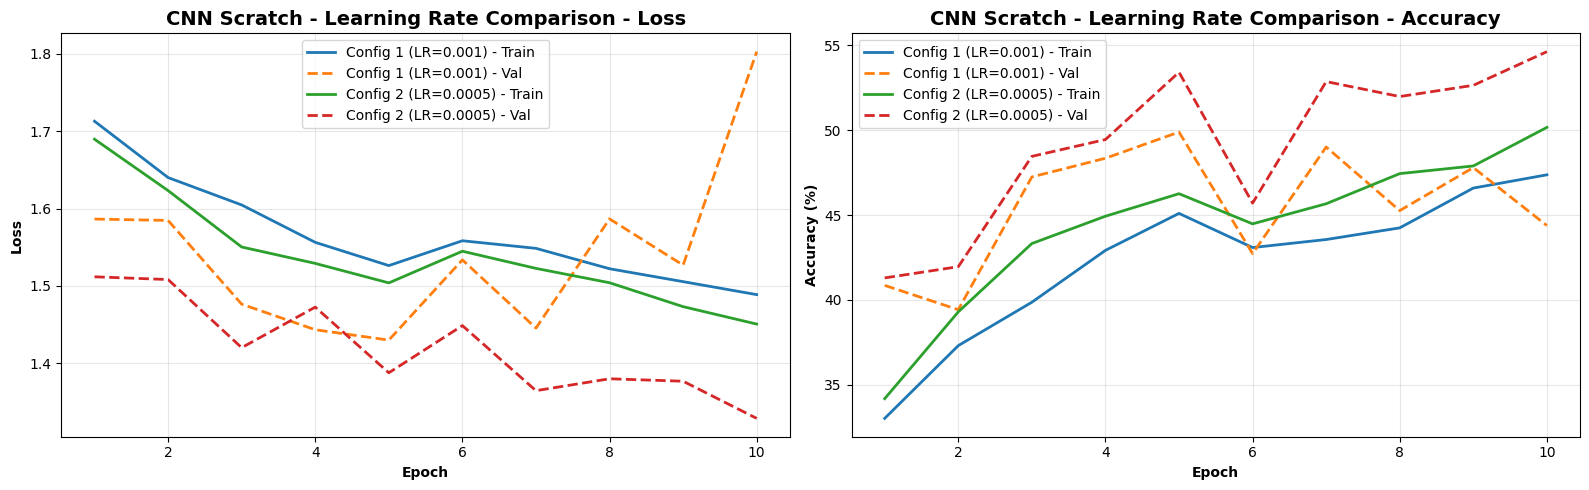

✓ Training curves saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/cnn_scratch_comparison.png

HYPERPARAMETER COMPARISON
Configuration                            Best Val Acc    Test Acc       
CNN LR=0.001                             49.89           0.00           
CNN LR=0.0005                            53.41           0.00           


In [ ]:
### Cell 13: Compare CNN Configurations ###
print("\n" + "="*80)
print("CNN SCRATCH - HYPERPARAMETER COMPARISON")
print("="*80)

# Plot comparison
histories = {
    'Config 1 (LR=0.001)': history_scratch_1,
    'Config 2 (LR=0.0005)': history_scratch_2
}
visualizer.plot_training_history(histories,
                                filename='cnn_scratch_comparison.png',
                                title='CNN Scratch - Learning Rate Comparison')

# Create comparator
hp_comparator = HyperparameterComparator(config.results_dir)
hp_comparator.add_result('CNN LR=0.001', history_scratch_1, best_val_acc_1)
hp_comparator.add_result('CNN LR=0.0005', history_scratch_2, best_val_acc_2)
hp_comparator.print_comparison()

In [ ]:
### Cell 14: Transfer Learning - Feature Extraction ###
print("\n" + "="*80)
print("PHASE 8: TRANSFER LEARNING")
print("="*80)

print("\n[STRATEGY 1: FEATURE EXTRACTION - Frozen Backbone]")
model_transfer_frozen = TransferLearningModel(config.num_classes)
model_transfer_frozen.freeze_backbone()

trainer_transfer_frozen = Trainer(config, model_transfer_frozen, 'transfer_frozen')
history_frozen, best_val_frozen = trainer_transfer_frozen.train(
    train_loader, val_loader,
    learning_rate=config.learning_rate_transfer,
    num_epochs=config.epochs,
    resume=True
)

print(f"\n✓ Feature Extraction Best Val Acc: {best_val_frozen:.2f}%")


PHASE 8: TRANSFER LEARNING

[STRATEGY 1: FEATURE EXTRACTION - Frozen Backbone]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


✓ Loaded checkpoint from epoch 10
✓ Resuming from epoch 11

TRAINING: transfer_frozen
Learning Rate: 0.0001
Epochs: 11 to 10
Batch Size: 64
Num Classes: 8


TRAINING COMPLETE: transfer_frozen
Best Val Acc: 76.32%


✓ Feature Extraction Best Val Acc: 76.32%


In [ ]:
### Cell 15: Transfer Learning - Partial Fine-tuning ###
print("\n[STRATEGY 2: PARTIAL FINE-TUNING - Unfreeze Layer4]")
model_transfer_partial = TransferLearningModel(config.num_classes)
model_transfer_partial.unfreeze_last_block()

trainer_transfer_partial = Trainer(config, model_transfer_partial, 'transfer_partial')
history_partial, best_val_partial = trainer_transfer_partial.train(
    train_loader, val_loader,
    learning_rate=config.learning_rate_transfer,
    num_epochs=config.epochs,
    resume=True
)

print(f"\n✓ Partial Fine-tuning Best Val Acc: {best_val_partial:.2f}%")


[STRATEGY 2: PARTIAL FINE-TUNING - Unfreeze Layer4]
✓ Loaded checkpoint from epoch 10
✓ Resuming from epoch 11

TRAINING: transfer_partial
Learning Rate: 0.0001
Epochs: 11 to 10
Batch Size: 64
Num Classes: 8


TRAINING COMPLETE: transfer_partial
Best Val Acc: 92.62%


✓ Partial Fine-tuning Best Val Acc: 92.62%


In [ ]:
### Cell 16: Transfer Learning - Full Fine-tuning ###
print("\n[STRATEGY 3: FULL FINE-TUNING - All Layers]")
model_transfer_full = TransferLearningModel(config.num_classes)
model_transfer_full.unfreeze_all()

trainer_transfer_full = Trainer(config, model_transfer_full, 'transfer_full')
history_full, best_val_full = trainer_transfer_full.train(
    train_loader, val_loader,
    learning_rate=config.learning_rate_transfer * 0.1,  # Lower LR for full fine-tuning
    num_epochs=config.epochs,
    resume=True
)

print(f"\n✓ Full Fine-tuning Best Val Acc: {best_val_full:.2f}%")


[STRATEGY 3: FULL FINE-TUNING - All Layers]
✓ Loaded checkpoint from epoch 10
✓ Resuming from epoch 11

TRAINING: transfer_full
Learning Rate: 1e-05
Epochs: 11 to 10
Batch Size: 64
Num Classes: 8


TRAINING COMPLETE: transfer_full
Best Val Acc: 91.41%


✓ Full Fine-tuning Best Val Acc: 91.41%



TRANSFER LEARNING - STRATEGY COMPARISON


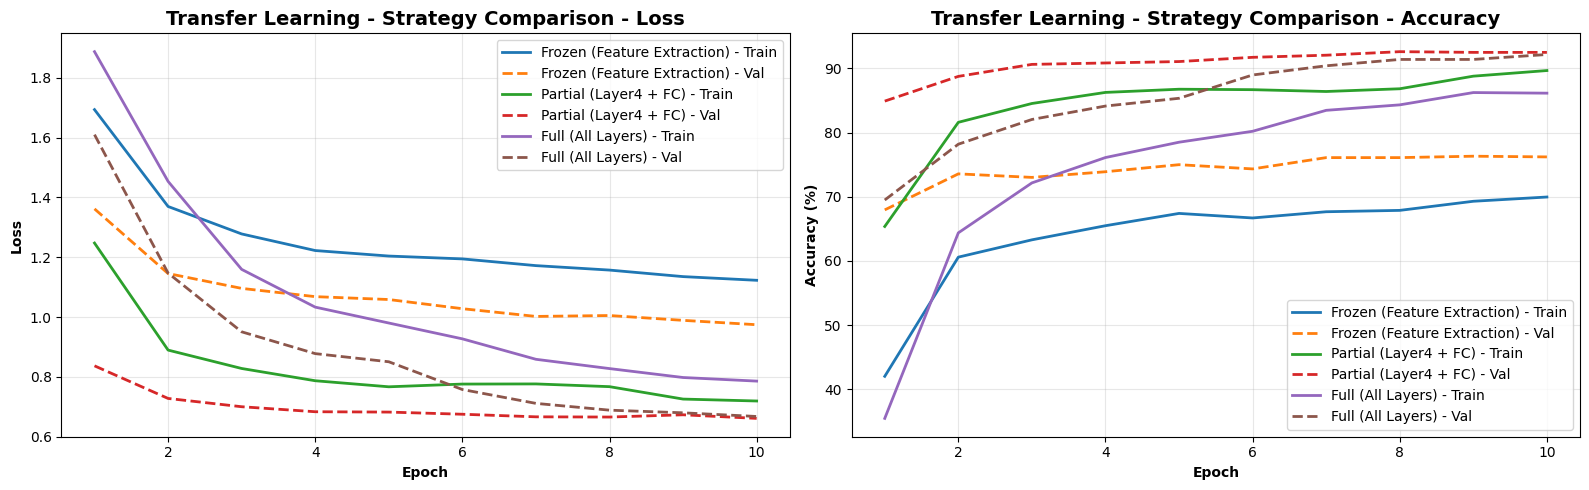

✓ Training curves saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/transfer_learning_comparison.png

Validation Accuracy Summary:
  Feature Extraction: 76.32%
  Partial Fine-tuning: 92.62%
  Full Fine-tuning: 91.41%


In [ ]:
### Cell 17: Compare Transfer Learning Strategies ###
print("\n" + "="*80)
print("TRANSFER LEARNING - STRATEGY COMPARISON")
print("="*80)

# Plot comparison
histories_transfer = {
    'Frozen (Feature Extraction)': history_frozen,
    'Partial (Layer4 + FC)': history_partial,
    'Full (All Layers)': history_full
}
visualizer.plot_training_history(histories_transfer,
                                filename='transfer_learning_comparison.png',
                                title='Transfer Learning - Strategy Comparison')

print(f"\nValidation Accuracy Summary:")
print(f"  Feature Extraction: {best_val_frozen:.2f}%")
print(f"  Partial Fine-tuning: {best_val_partial:.2f}%")
print(f"  Full Fine-tuning: {best_val_full:.2f}%")


In [ ]:
### Cell 18: Load Best Models for Evaluation ###
print("\n" + "="*80)
print("PHASE 9: MODEL EVALUATION")
print("="*80)

# Load best CNN model (choose better config)
if best_val_acc_1 > best_val_acc_2:
    best_cnn_name = 'cnn_scratch_lr0.001'
    best_cnn_acc = best_val_acc_1
else:
    best_cnn_name = 'cnn_scratch_lr0.0005'
    best_cnn_acc = best_val_acc_2

model_cnn_best = CNNFromScratch(config.num_classes).to(config.device)
cnn_checkpoint_path = os.path.join(config.models_dir, f'{best_cnn_name}_best.pth')
cnn_checkpoint = torch.load(cnn_checkpoint_path, map_location=config.device)
model_cnn_best.load_state_dict(cnn_checkpoint['model_state_dict'])
print(f"✓ Loaded best CNN: {best_cnn_name} (Val Acc: {best_cnn_acc:.2f}%)")

# Load best Transfer Learning model (usually partial)
model_transfer_best = TransferLearningModel(config.num_classes).to(config.device)
transfer_checkpoint_path = os.path.join(config.models_dir, 'transfer_partial_best.pth')
transfer_checkpoint = torch.load(transfer_checkpoint_path, map_location=config.device)
model_transfer_best.load_state_dict(transfer_checkpoint['model_state_dict'])
print(f"✓ Loaded best Transfer: transfer_partial (Val Acc: {best_val_partial:.2f}%)")



PHASE 9: MODEL EVALUATION
✓ Loaded best CNN: cnn_scratch_lr0.0005 (Val Acc: 53.41%)
✓ Loaded best Transfer: transfer_partial (Val Acc: 92.62%)



[EVALUATING CNN FROM SCRATCH]


Evaluating: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]



EVALUATION REPORT
Overall Accuracy: 58.12%
Macro Precision:  0.6187
Macro Recall:     0.5805
Macro F1-Score:   0.5804

Class                                    Precision    Recall       F1-Score     Support   
Atolla                                   0.3949       0.4968       0.4400       155       
Farrea                                   0.8777       0.8079       0.8414       151       
Physonectae                              0.6780       0.2703       0.3865       148       
Vampyroteuthis infernalis                0.4977       0.6815       0.5753       157       
larvacean                                0.4751       0.5443       0.5074       158       
squid                                    0.7891       0.6824       0.7319       148       

Most Confused Class Pairs (>10% confusion rate):
  Physonectae → Atolla: 29.7%
  Physonectae → Vampyroteuthis infernalis: 20.9%
  larvacean → Atolla: 20.9%
  Vampyroteuthis infernalis → Atolla: 20.4%
  Physonectae → larvacean: 20.3%
  Atolla 

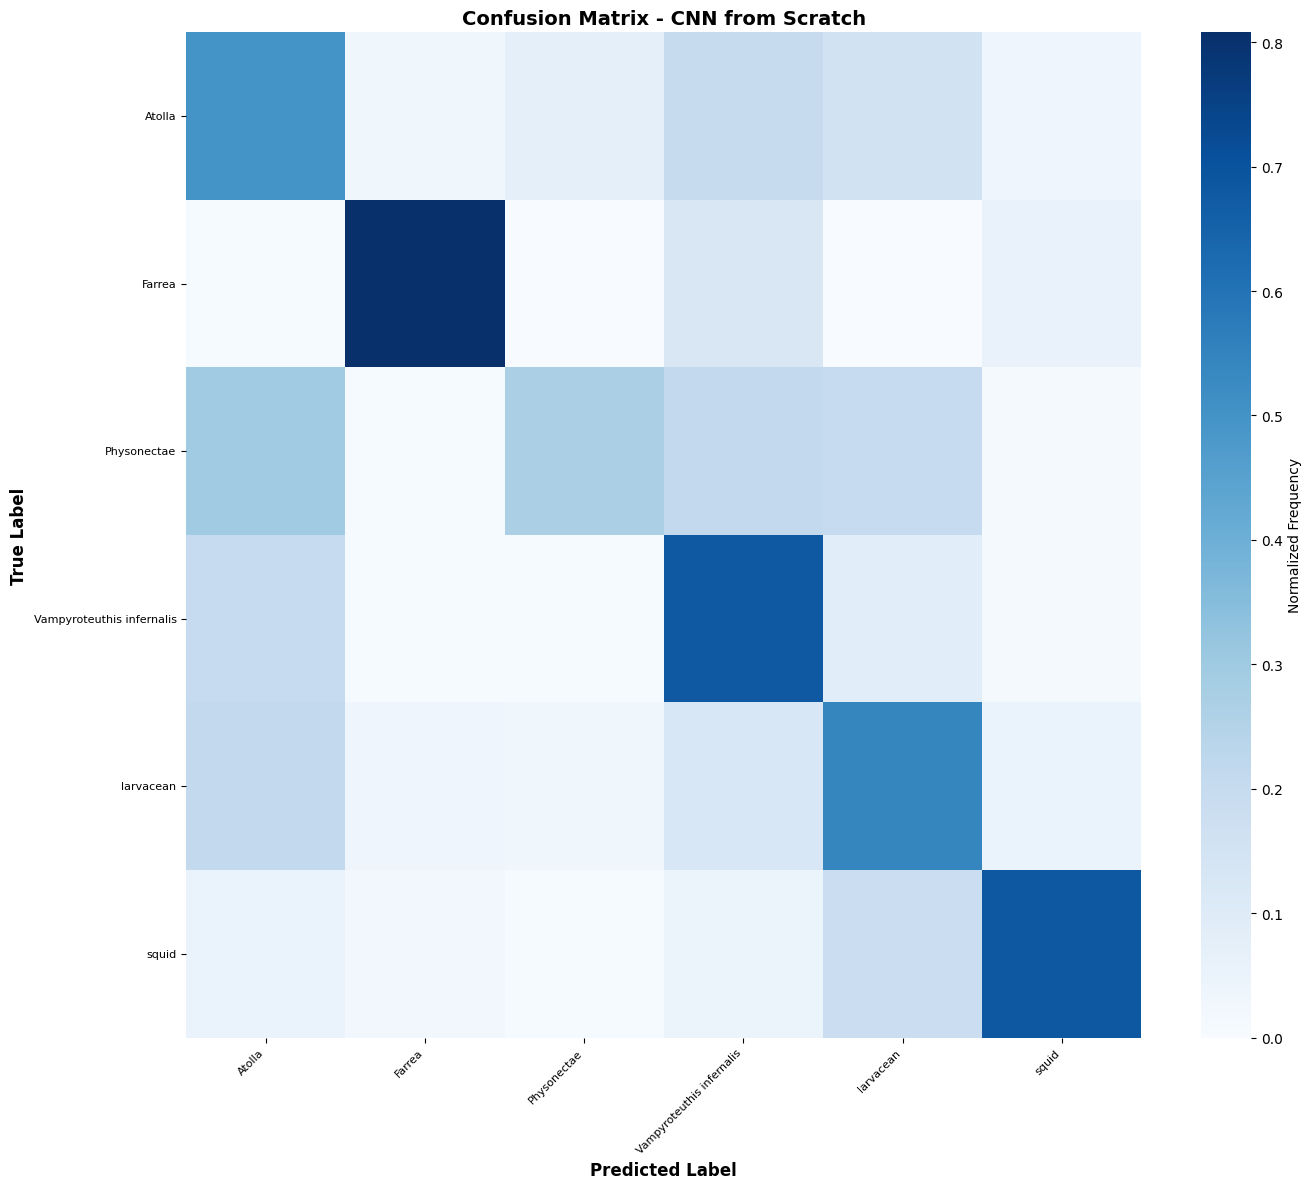

✓ Confusion matrix saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/confusion_matrix_cnn_scratch.png


'/content/drive/MyDrive/FathomNet_Project/results_8classes/confusion_matrix_cnn_scratch.png'

In [ ]:
### Cell 19: Evaluate CNN on Test Set ###
print("\n[EVALUATING CNN FROM SCRATCH]")
evaluator_cnn = ModelEvaluator(model_cnn_best, config.device, idx_to_class)
results_cnn = evaluator_cnn.evaluate(test_loader, return_predictions=True)
evaluator_cnn.print_evaluation_report(results_cnn['metrics'])
evaluator_cnn.print_confused_pairs(np.array(results_cnn['metrics']['confusion_matrix']))

# Plot confusion matrix - FIX: Use actual number of classes from idx_to_class
actual_num_classes = len(idx_to_class)
visualizer.plot_confusion_matrix(
    np.array(results_cnn['metrics']['confusion_matrix']),
    [idx_to_class[i] for i in range(actual_num_classes)],  # Fixed
    normalize=True,
    filename='confusion_matrix_cnn_scratch.png',
    title='Confusion Matrix - CNN from Scratch'
)


[EVALUATING TRANSFER LEARNING]


Evaluating: 100%|██████████| 8/8 [00:24<00:00,  3.07s/it]



EVALUATION REPORT
Overall Accuracy: 90.73%
Macro Precision:  0.9083
Macro Recall:     0.9073
Macro F1-Score:   0.9075

Class                                    Precision    Recall       F1-Score     Support   
Atolla                                   0.8457       0.8839       0.8644       155       
Farrea                                   0.9739       0.9868       0.9803       151       
Physonectae                              0.8377       0.8716       0.8543       148       
Vampyroteuthis infernalis                0.9730       0.9172       0.9443       157       
larvacean                                0.9156       0.8924       0.9038       158       
squid                                    0.9041       0.8919       0.8980       148       

No significant class confusion detected.


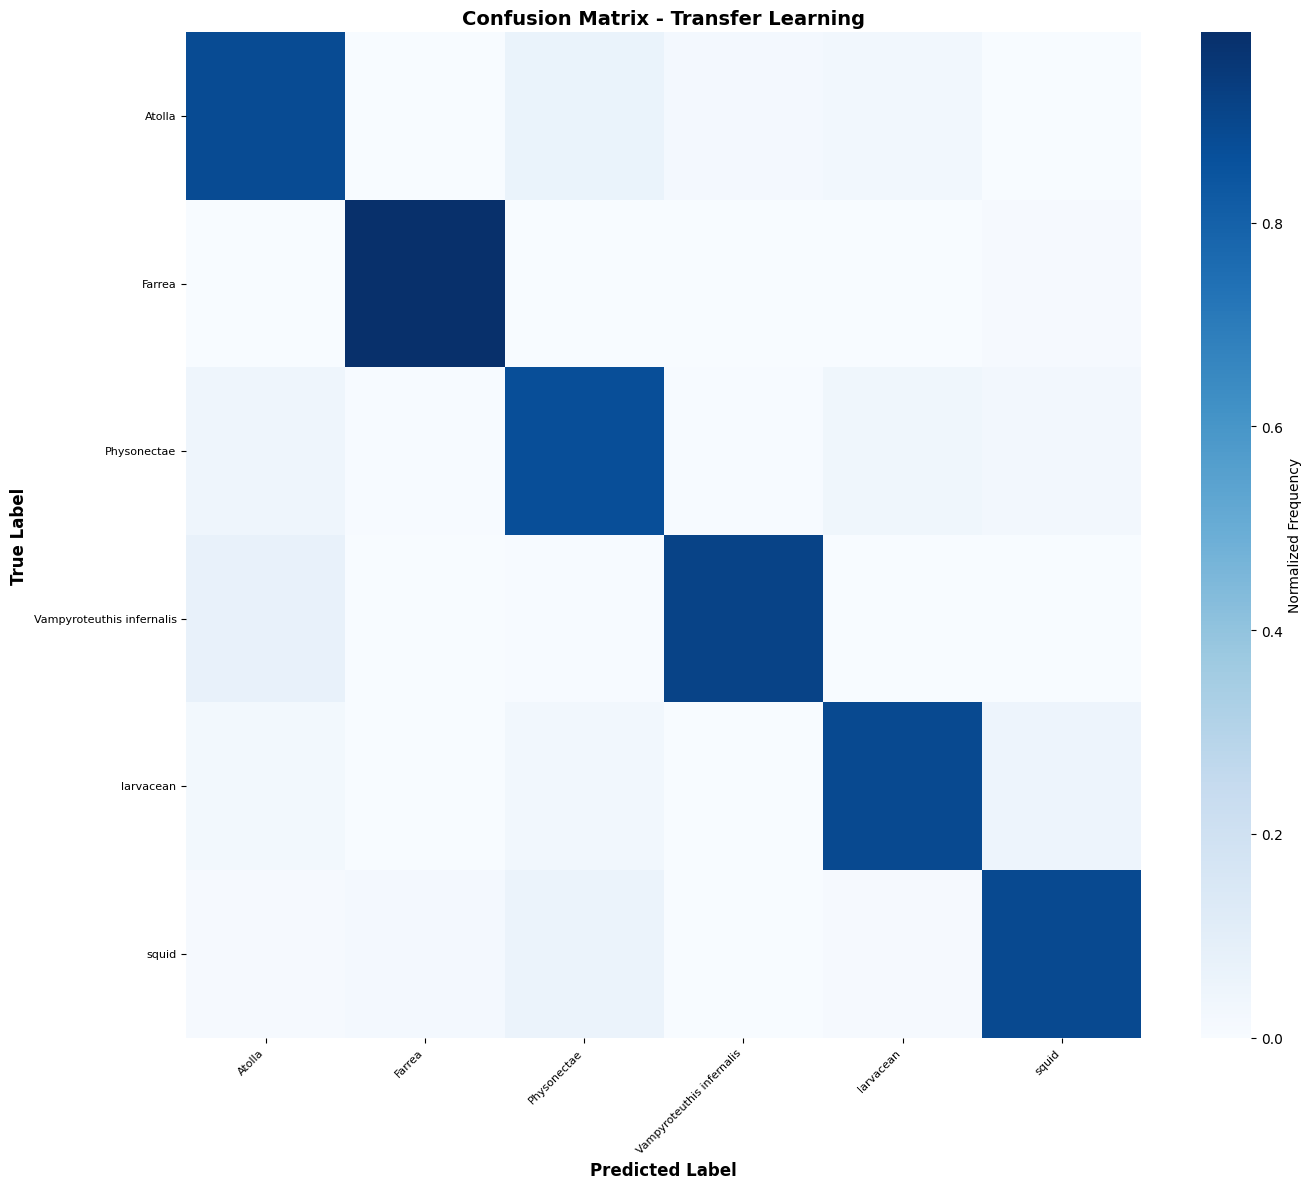

✓ Confusion matrix saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/confusion_matrix_transfer_learning.png


'/content/drive/MyDrive/FathomNet_Project/results_8classes/confusion_matrix_transfer_learning.png'

In [ ]:
### Cell 20: Evaluate Transfer Learning on Test Set ###
print("\n[EVALUATING TRANSFER LEARNING]")
evaluator_transfer = ModelEvaluator(model_transfer_best, config.device, idx_to_class)
results_transfer = evaluator_transfer.evaluate(test_loader, return_predictions=True)
evaluator_transfer.print_evaluation_report(results_transfer['metrics'])
evaluator_transfer.print_confused_pairs(np.array(results_transfer['metrics']['confusion_matrix']))

# Plot confusion matrix - FIX: Use actual number of classes
actual_num_classes = len(idx_to_class)
visualizer.plot_confusion_matrix(
    np.array(results_transfer['metrics']['confusion_matrix']),
    [idx_to_class[i] for i in range(actual_num_classes)],  # Fixed
    normalize=True,
    filename='confusion_matrix_transfer_learning.png',
    title='Confusion Matrix - Transfer Learning'
)

In [ ]:
### Cell 21: Model Comparison Summary ###
print("\n" + "="*80)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*80)

comparison_results = {
    'CNN from Scratch': results_cnn,
    'Transfer Learning (Partial)': results_transfer
}

evaluator_cnn.compare_models(comparison_results)

# Save comparison table
model_comparison = {
    'CNN from Scratch': {
        'val_acc': best_cnn_acc,
        'test_acc': results_cnn['metrics']['accuracy'],
        'macro_f1': results_cnn['metrics']['macro_f1'],
        'macro_precision': results_cnn['metrics']['macro_precision'],
        'macro_recall': results_cnn['metrics']['macro_recall']
    },
    'Transfer Learning': {
        'val_acc': best_val_partial,
        'test_acc': results_transfer['metrics']['accuracy'],
        'macro_f1': results_transfer['metrics']['macro_f1'],
        'macro_precision': results_transfer['metrics']['macro_precision'],
        'macro_recall': results_transfer['metrics']['macro_recall']
    }
}

visualizer.create_comparison_table(model_comparison)



MODEL COMPARISON - TEST SET PERFORMANCE

MODEL COMPARISON
Model                          Accuracy     Macro F1     Macro Prec   Macro Rec   
CNN from Scratch               58.12        0.5804       0.6187       0.5805      
Transfer Learning (Partial)    90.73        0.9075       0.9083       0.9073      

MODEL COMPARISON SUMMARY
            Model Val Accuracy (%) Test Accuracy (%) Macro F1 Macro Precision Macro Recall
 CNN from Scratch            53.41             58.12   0.5804          0.6187       0.5805
Transfer Learning            92.62             90.73   0.9075          0.9083       0.9073

✓ Comparison table saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/model_comparison.csv


'/content/drive/MyDrive/FathomNet_Project/results_8classes/model_comparison.csv'

In [ ]:
### Cell 22: OOD Detection - Test on Known Samples ###
print("\n" + "="*80)
print("PHASE 10: OUT-OF-DISTRIBUTION DETECTION")
print("="*80)

print("\n[OOD DETECTION ON KNOWN TEST SAMPLES]")
ood_detector = OODDetector(threshold=config.ood_threshold)

# Get probabilities for known test samples
probs_known = results_transfer['probabilities']

# Detect OOD
ood_flags_known, max_probs_known = ood_detector.detect_ood(probs_known)

print(f"Results on Known Test Set:")
print(f"  Total samples: {len(ood_flags_known)}")
print(f"  Flagged as OOD: {np.sum(ood_flags_known)} "
      f"({100*np.sum(ood_flags_known)/len(ood_flags_known):.2f}%)")
print(f"  Correctly identified: {len(ood_flags_known) - np.sum(ood_flags_known)} "
      f"({100*(len(ood_flags_known)-np.sum(ood_flags_known))/len(ood_flags_known):.2f}%)")



PHASE 10: OUT-OF-DISTRIBUTION DETECTION

[OOD DETECTION ON KNOWN TEST SAMPLES]
Results on Known Test Set:
  Total samples: 917
  Flagged as OOD: 339 (36.97%)
  Correctly identified: 578 (63.03%)


In [ ]:
### Cell 23: OOD Detection - Test on Unknown Classes ###
print("\n[OOD DETECTION ON UNKNOWN CLASSES]")

# Evaluate on OOD dataset
results_ood = evaluator_transfer.evaluate(ood_loader, return_predictions=True)
probs_unknown = results_ood['probabilities']

# Detect OOD
ood_flags_unknown, max_probs_unknown = ood_detector.detect_ood(probs_unknown)

print(f"Results on Unknown Classes:")
print(f"  Total samples: {len(ood_flags_unknown)}")
print(f"  Correctly flagged as OOD: {np.sum(ood_flags_unknown)} "
      f"({100*np.sum(ood_flags_unknown)/len(ood_flags_unknown):.2f}%)")
print(f"  Missed: {len(ood_flags_unknown) - np.sum(ood_flags_unknown)} "
      f"({100*(len(ood_flags_unknown)-np.sum(ood_flags_unknown))/len(ood_flags_unknown):.2f}%)")



[OOD DETECTION ON UNKNOWN CLASSES]


Evaluating: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]

Results on Unknown Classes:
  Total samples: 1999
  Correctly flagged as OOD: 1071 (53.58%)
  Missed: 928 (46.42%)



[OOD DETECTION - COMPREHENSIVE EVALUATION]

OUT-OF-DISTRIBUTION DETECTION RESULTS
Threshold: 0.88

Overall Performance:
  Accuracy:  0.5655
  Precision: 0.7596
  Recall:    0.5358
  F1-Score:  0.6283
  ROC AUC:   0.5996

Known Samples (should NOT be flagged as OOD):
  Total: 917
  Flagged as OOD: 339 (36.97%)
  Correctly identified: 578 (63.03%)

Unknown Samples (SHOULD be flagged as OOD):
  Total: 1999
  Flagged as OOD: 1071 (53.58%)
  Missed: 928 (46.42%)
✓ OOD results saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/ood_results.json

CONFIDENCE DISTRIBUTION ANALYSIS

Known Samples:
  Mean:   0.8557
  Median: 0.9101
  Std:    0.1413
  Range:  [0.2784, 0.9958]

Unknown Samples:
  Mean:   0.7847
  Median: 0.8649
  Std:    0.1908
  Range:  [0.2128, 0.9929]

Separation:
  Mean difference: 0.0709
  Overlap: Yes


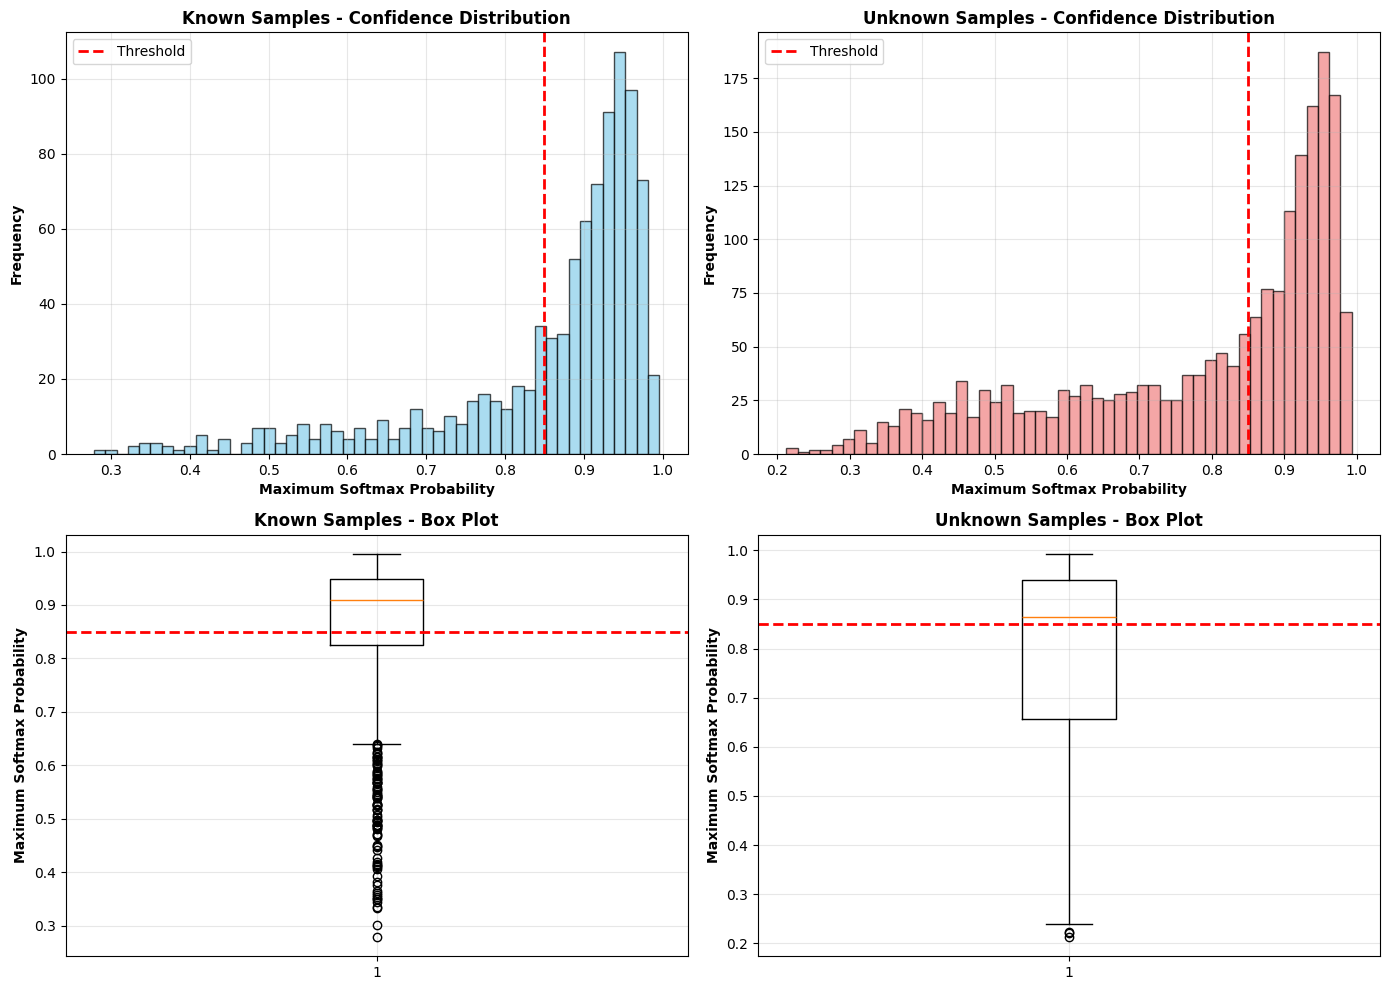

✓ OOD analysis saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/ood_analysis.png


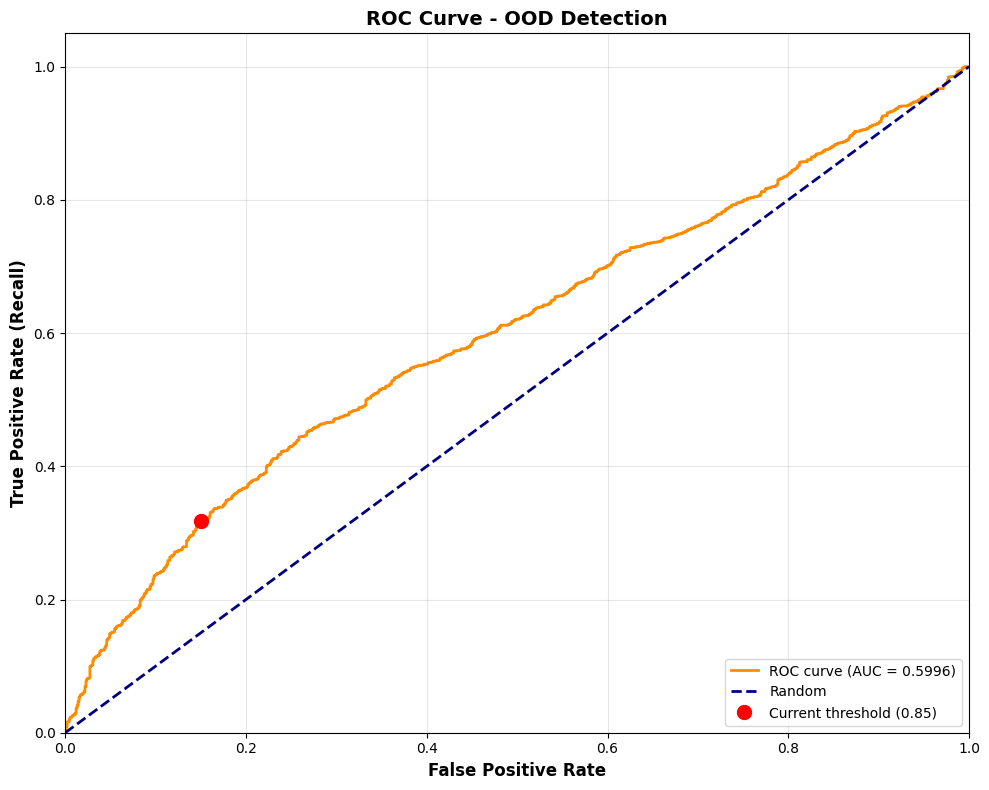

✓ ROC curve saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/ood_roc_curve.png


'/content/drive/MyDrive/FathomNet_Project/results_8classes/ood_roc_curve.png'

In [ ]:
### Cell 24: OOD Detection - Comprehensive Evaluation ###
print("\n[OOD DETECTION - COMPREHENSIVE EVALUATION]")

# Evaluate OOD detection
ood_results = ood_detector.evaluate_ood_detection(probs_known, probs_unknown)
ood_detector.print_ood_results(ood_results)

# Save results
ood_results_path = os.path.join(config.results_dir, 'ood_results.json')
ood_detector.save_results(ood_results, ood_results_path)

# Analyze confidence distributions
analyzer = OODAnalyzer()
confidence_analysis = analyzer.analyze_confidence_distribution(probs_known, probs_unknown)
analyzer.print_confidence_analysis(confidence_analysis)

# Plot OOD analysis
visualizer.plot_ood_analysis(
    max_probs_known, max_probs_unknown, config.ood_threshold,
    filename='ood_analysis.png'
)

# Plot ROC curve
visualizer.plot_roc_curve(
    np.array(ood_results['fpr']),
    np.array(ood_results['tpr']),
    ood_results['roc_auc'],
    config.ood_threshold,
    filename='ood_roc_curve.png'
)


In [ ]:
### Cell 25: Final Summary & Report Generation ###
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

# Generate final report
from src.visualization.reports import ReportGenerator

report_gen = ReportGenerator(config.results_dir)
report_gen.generate_final_report(
    config=config,
    cnn_results=results_cnn['metrics'],
    transfer_results=results_transfer['metrics'],
    ood_results=ood_results,
    hyperparameter_comparison={
        'CNN LR=0.001': best_val_acc_1,
        'CNN LR=0.0005': best_val_acc_2
    },
    transfer_comparison={
        'Feature Extraction': best_val_frozen,
        'Partial Fine-tuning': best_val_partial,
        'Full Fine-tuning': best_val_full
    },
    ood_classes=ood_classes
)

print("\n" + "="*80)
print("PROJECT COMPLETE!")
print("="*80)
print(f"\n📁 All results saved to: {config.results_dir}")
print(f"📁 Models saved to: {config.models_dir}")
print(f"📁 Checkpoints saved to: {config.checkpoint_dir}")
print("\n✓ Review the generated plots and reports for your technical report!")



FINAL SUMMARY
✓ Final report saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/final_report_summary.txt
✓ JSON report saved to: /content/drive/MyDrive/FathomNet_Project/results_8classes/final_report.json

FATHOMNET MARINE ORGANISM CLASSIFICATION - FINAL REPORT
Generated: 2025-12-04 19:19:24

PROJECT CONFIGURATION
--------------------------------------------------------------------------------
Number of classes: 8
Image size: 160x160
Batch size: 64
Training epochs: 10
Device: cuda

DATASET INFORMATION
--------------------------------------------------------------------------------
Training classes: 8
OOD classes (held out): 2
OOD classes: manipulator, Merluccius productus

MODEL A: CNN FROM SCRATCH
--------------------------------------------------------------------------------
Hyperparameter Comparison:
  CNN LR=0.001: 49.89%
  CNN LR=0.0005: 53.41%

Best Configuration Test Results:
  Test Accuracy: 58.12%
  Macro F1-Score: 0.5804
  Macro Precision: 0.6187
  Macro Re